# KernelKit concepts explained in code

This notebook is provided along the tutorial _KernelKit concepts explained in
code_, found in the main documentation.

The codes in this notebook are modified for the purpose of demonstration and readability. Take the KernelKit sources
as a starting point for your own projects.

In [7]:
import cupy as cp
import kernelkit
import matplotlib.pyplot as plt
import numpy as np

## 1. CUDA source


In [8]:
cuda_source = """
__device__ __inline__ float linearly_interpolate(
    const float * sinogram,
    const int i,
    const int nr_pixels,
    const float x
) {
    if (x < 0.0 || x >= nr_pixels)
        return 0.0;
    float y1 = sinogram[i * nr_pixels + int(floor(x))];
    float y2 = sinogram[i * nr_pixels + int(ceil(x))];
    return y1 + (y2 - y1) * (x - floor(x));
}

__global__ void demo_fan_bp(
    float * volume, float * sinogram, float * angles,
    int nr_angles, int nr_voxels_x, int nr_voxels_y, int nr_pixels,
    float src_obj_dist, float obj_det_dist
) {
    // X, Y are the voxel's center coordinates of this thread
    unsigned x = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned y = blockIdx.y * blockDim.y + threadIdx.y;
    float X = float(x) - nr_voxels_x / 2.0 + 0.5;
    float Y = float(y) - nr_voxels_y / 2.0 + 0.5;

    // ignore threads outside the volume
    if (x >= nr_voxels_x || y >= nr_voxels_y)
        return;

    for (int i = 0; i < nr_angles; i++) {
        // project the voxel (X, Y) onto a coordinate U on the detector line
        float src_sin = sin(angles[i]);
        float src_cos = cos(angles[i]);
        float ray_fact = (src_obj_dist + obj_det_dist)
                         / (src_obj_dist + -src_cos * Y + src_sin * X);
        float U = (src_cos * X + src_sin * Y ) * ray_fact + nr_pixels / 2.0;

        // linearly interpolate the value at U from sinogram gridpoints
        volume[y * nr_voxels_x + x] += linearly_interpolate(sinogram, i, nr_pixels, U);
    }
}
"""

## 2. kernelkit.Kernel

In [9]:
class DemoFanBp(kernelkit.kernel.BaseKernel):
    """Fanbeam backprojection for circular geometry."""

    def __init__(self):
        super().__init__(cuda_source)

    def compile(self):
        self._compile(("demo_fan_bp",))

    def __call__(self, volume: cp.ndarray, sinogram: cp.ndarray,
                 angles: cp.ndarray, src_dist: float, det_dist: float):
        # here we retrieve a function using CuPy
        demo_fan_bp = self._module.get_function("demo_fan_bp")

        # calling the module launches the kernel from the code example above
        demo_fan_bp(
            (32, 32),                                                # CUDA threads
            (volume.shape[1] // 32 + 1, volume.shape[0] // 32 + 1),  # CUDA blocks
            (                                                        # arguments
                volume, sinogram, angles,
                len(angles), *volume.T.shape, sinogram.shape[1],  # width, height, det_count
                cp.float32(src_dist), cp.float32(det_dist)
            )
        )

In principle, we can already use the kernel for backprojection. The following
example creates a $(N_\theta, N_u)$ sinogram, and backprojects this along a
circular geometry. The sinogram is filled with the value $1.0$. Without a filter,
like is present in the filtered-backprojection method, this creates a blurred
sphere in the backprojected image.

Compiling kernel DemoFanBp: demo_fan_bp...


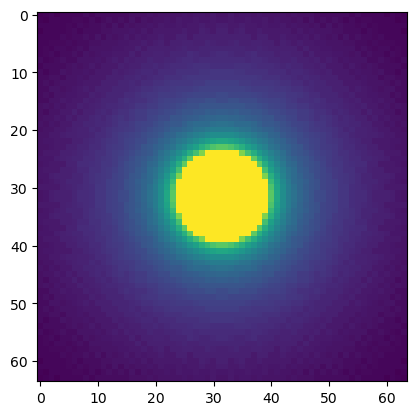

In [10]:
N_theta, N_u = 128, 32
N_x, N_y = 64, 64
output = cp.zeros((N_x, N_y), dtype=cp.float32)
data = cp.ones((N_theta, N_u), dtype=cp.float32)

fan_bp = DemoFanBp()
fan_bp.compile()
fan_bp(output, data,
       angles=cp.linspace(0, 2 * cp.pi, N_theta, False, dtype=cp.float32),
       src_dist=150.,
       det_dist=150.)

plt.figure()
plt.imshow(output.get())
# the kernel has written in `output`

## 3. kernelkit.Projector

In [12]:
class DemoFanbeamBackProjector(kernelkit.BaseProjector):
    """Chunking backprojection for a circular 2D geometry."""

    def __init__(self, nr_chunks: int):
        super(DemoFanbeamBackProjector, self).__init__()
        
        self._kernel = DemoFanBp()
        self._kernel.compile()
        assert nr_chunks > 0
        self._nr_chunks = nr_chunks
        
    @property
    def projection_geometry(self) -> dict:
        return self._geom

    @projection_geometry.setter
    def projection_geometry(self, geometry: dict):
        self._geom = geometry

    @property
    def volume_geometry(self):
        return None

    @property
    def projection_axes(self) -> tuple:
        return 0, 1  # N_theta, N_u

    @property
    def volume_axes(self) -> tuple:
        return 0, 1  # N_x, N_y

    @property
    def volume(self):
        return self._vol

    @volume.setter
    def volume(self, volume):
        self._vol = volume

    @property
    def projections(self):
        return self._projs

    @projections.setter
    def projections(self, projections):
        self._projs = projections

    def __call__(self, **kwargs):
        # split the projection indices and the geometry angles in chunks
        inds = np.array_split(np.arange(len(self._geom['angles'])),
                              self._nr_chunks)
        angles = np.array_split(self._geom['angles'],
                                self._nr_chunks)

        # chunk-by-chunk
        for inds, angles in zip(inds, angles):
            print(f"Uploading and backprojecting [{inds[0]}, {inds[-1]})...")

            self._kernel(
                self.volume,
                cp.asarray(self.projections[inds]),  # upload
                angles,                              # angular subset
                self._geom['src_obj_dist'],
                self._geom['obj_det_dist'])


Above the concept of a projector is demonstrated, here with functionality to chunk sinogram data. For larger angular data sets, chunking handles GPU memory more economically.  The example below uploads and backproject $N_\theta$ angles in 7 chunks.

Compiling kernel DemoFanBp: demo_fan_bp...
Uploading and backprojecting [0, 349)...


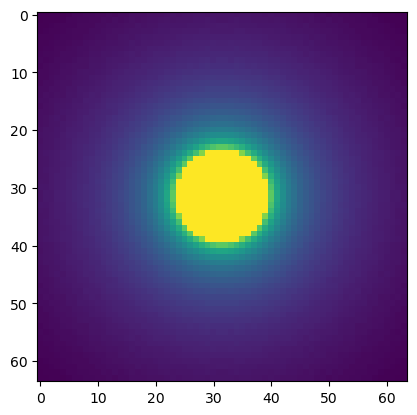

In [15]:
angles = cp.linspace(0, 2 * cp.pi, 350, endpoint=False, dtype=cp.float32)

bp = DemoFanbeamBackProjector(nr_chunks=1)
bp.volume = output
bp.projections = data
bp.projection_geometry = {
    'angles': angles, 
    'src_obj_dist': 400,
    'obj_det_dist': 400,}
bp()  # invokes __call__

plt.figure()
plt.imshow(output.get())
plt.show()